### 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import umap
import datatable as dt
import scanpy as sc
import pickle

from sklearn.metrics.cluster import adjusted_rand_score

from WEST import WEST
import WEST_plt

file_path = '/home/stat/cai/WEST/data/cancer/'

2024-06-23 20:24:32.021833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 20:24:32.569940: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 20:24:35.767415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-23 20:24:35.768477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Load embedding & clustering result

In [3]:
adata.obsm['Leiden'] = np.genfromtxt(file_path+'Leiden_embedding.csv', delimiter=',')
adata.obsm['SpaGCN'] = np.genfromtxt(file_path+'SpaGCN_embedding.csv', delimiter=',')
adata.obsm['SpaceFlow'] = np.genfromtxt(file_path+'SpaceFlow_embedding.csv', delimiter=',')
adata.obsm['SEDR'] = np.genfromtxt(file_path+'SEDR_embedding.csv', delimiter=',')
adata.obsm['STAGATE'] = np.genfromtxt(file_path+'STAGATE_embedding.csv', delimiter=',')
adata.obsm['DeepST'] = np.genfromtxt(file_path+'DeepST_embedding.csv', delimiter=',')

adata.obs['Leiden'] = np.genfromtxt(file_path+'Leiden_cluster.csv', delimiter=',', dtype=str)
adata.obs['SpaGCN'] = np.genfromtxt(file_path+'SpaGCN_cluster.csv', delimiter=',', dtype=str)
adata.obs['SpaceFlow'] = np.genfromtxt(file_path+'SpaceFlow_cluster.csv', delimiter=',', dtype=str)
adata.obs['SEDR'] = np.genfromtxt(file_path+'SEDR_cluster.csv', delimiter=',', dtype=str)
adata.obs['STAGATE'] = np.genfromtxt(file_path+'STAGATE_cluster.csv', delimiter=',', dtype=str)
adata.obs['DeepST'] = np.genfromtxt(file_path+'DeepST_cluster.csv', delimiter=',', dtype=str)

### 4. Run WEST

In [4]:
adata.obsm['SpaGCN'].shape

(2688, 50)

In [11]:
west_obj = WEST(adata, reps=['DeepST', 'STAGATE'], n_neighbors=10)
west_obj.compute_west()
adata_west = west_obj.adata

Computing KNN distance matrices using default Scanpy implementation


/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Computing modality weights
time: 0.30 seconds
Selecting top K neighbors


### 5. Clustering 

In [12]:
sc.tl.leiden(adata_west, key_added="WEST", obsp="WEST", resolution=0.4)
ARI_WEST = adjusted_rand_score(adata_west.obs["WEST"], adata_west.obs["true cluster"])
print("ARI: ", ARI_WEST)
print(adata_west.obs["WEST"].unique())

ARI:  0.683279494499851
['1', '0', '2', '3']
Categories (4, object): ['0', '1', '2', '3']


### 6. Generate new embedding

In [22]:
adata_west.obsm['WEST'] = west_obj.get_embedding(50)
west_obj.get_embedding(50)

array([[-3.38481114e-04,  1.78514198e-04, -2.01525468e-04, ...,
         8.92519691e-05,  1.71620666e-04,  2.13479558e-04],
       [ 5.21674890e-04,  1.51641799e-04, -1.02354415e-04, ...,
         6.60334973e-04,  6.73487357e-04, -4.26539997e-04],
       [ 1.12761064e-03, -9.82405960e-04,  1.11316505e-03, ...,
         8.91721955e-04, -1.74113626e-03,  2.82496167e-04],
       ...,
       [-2.93493129e-04, -9.58593034e-04,  1.24474393e-03, ...,
        -1.28952387e-03,  7.37286228e-04,  1.13028491e-03],
       [-1.49845570e-03, -3.24066068e-04, -1.07545651e-03, ...,
        -6.90685093e-04,  4.50876613e-04, -1.27020198e-03],
       [ 1.51600258e-04, -5.93868850e-04, -7.17593777e-04, ...,
        -1.00067073e-03, -6.07968588e-05,  7.08291709e-04]])

### 7. Compute ARI

In [13]:
print("ARI for WEST: ", adjusted_rand_score(adata_west.obs["WEST"], adata_west.obs["true cluster"]))
print("ARI for Leiden: ", adjusted_rand_score(adata_west.obs["Leiden"], adata_west.obs["true cluster"]))
print("ARI for SpaGCN: ", adjusted_rand_score(adata_west.obs["SpaGCN"], adata_west.obs["true cluster"]))
print("ARI for SpaceFlow: ", adjusted_rand_score(adata_west.obs["SpaceFlow"], adata_west.obs["true cluster"]))
print("ARI for SEDR: ", adjusted_rand_score(adata_west.obs["SEDR"], adata_west.obs["true cluster"]))
print("ARI for STAGATE: ", adjusted_rand_score(adata_west.obs["STAGATE"], adata_west.obs["true cluster"]))
print("ARI for DeepST: ", adjusted_rand_score(adata_west.obs["DeepST"], adata_west.obs["true cluster"]))

ARI for WEST:  0.683279494499851
ARI for Leiden:  0.460519217736938
ARI for SpaGCN:  0.5119870276269075
ARI for SpaceFlow:  0.5312847043343434
ARI for SEDR:  0.30418576621425497
ARI for STAGATE:  0.5473133562575203
ARI for DeepST:  0.6653391444113264


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

def WEST_scatter(adata, reps='WEST', title=None, cmap=None, s=5, width=5, height=5, switch_coordinate=False, invert_x=False, invert_y=False, save_path=None):
    adata_plt = adata.copy()
    adata_plt.obs[reps] = pd.Categorical(adata_plt.obs[reps])

    # Define color map if color map is not given
    if cmap is None:
        plot_color = ["#F56867", "#FEB915", "#C798EE", "#59BE86", "#7495D3", "#D1D1D1",
                    "#6D1A9C", "#15821E", "#3A84E6", "#997273", "#787878", "#DB4C6C",
                    "#9E7A7A", "#554236", "#AF5F3C", "#93796C", "#F9BD3F", "#DAB370",
                    "#877F6C", "#268785"] 
                    #["#F56867", "#FEB915", "#C798EE", "#59BE86"]  # Color list for clusters

    # Sorting categories by the median 'loc_x'
    categories = adata_plt.obs[reps].unique()
    median_locations = []
    for category in categories:
        subset = adata_plt[adata_plt.obs[reps] == category]
        median_x = subset.obs['loc_x'].median()
        median_locations.append((category, median_x))

    # Sort by 'loc_x'
    sorted_by_x = sorted(median_locations, key=lambda x: x[1])

    # Assign colors based on sorted position, looping over the color list
    color_dict = {}
    for idx, (category, _) in enumerate(sorted_by_x):
        color_dict[category] = plot_color[idx % len(plot_color)]

    # Set figure size
    plt.figure(figsize=(width, height))

    # Plot each category separately to assign colors
    if switch_coordinate:
        for category in categories:
            subset = adata_plt[adata_plt.obs[reps] == category]
            plt.scatter(subset.obs['loc_y'], subset.obs['loc_x'], c=color_dict[category], label=category, s=s, alpha=1)
    else:
        for category in categories:
            subset = adata_plt[adata_plt.obs[reps] == category]
            plt.scatter(subset.obs['loc_x'], subset.obs['loc_y'], c=color_dict[category], label=category, s=s, alpha=1)
        
    # Invert axis if necessary
    if invert_x:
        plt.gca().invert_xaxis()
    if invert_y:
        plt.gca().invert_yaxis()

    # Add a legend
    legend = plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(1.0)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    if title is not None:
        plt.title(title)

    # Save the plot if a path is provided
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Show the plot
    plt.show()


### 8. Visualization

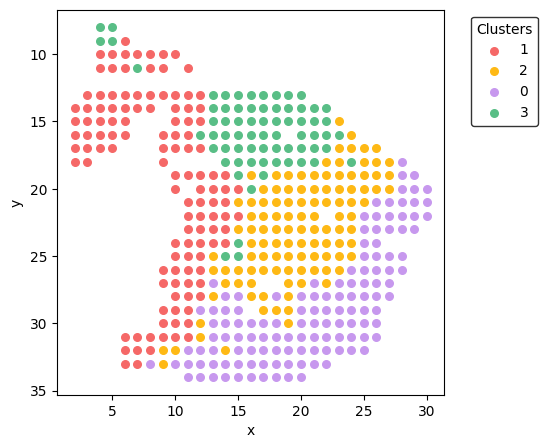

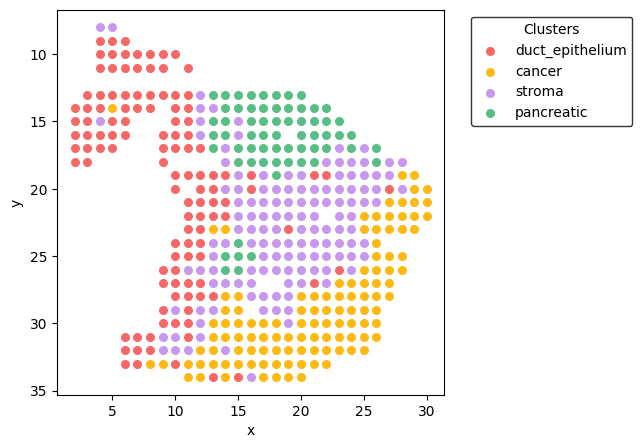

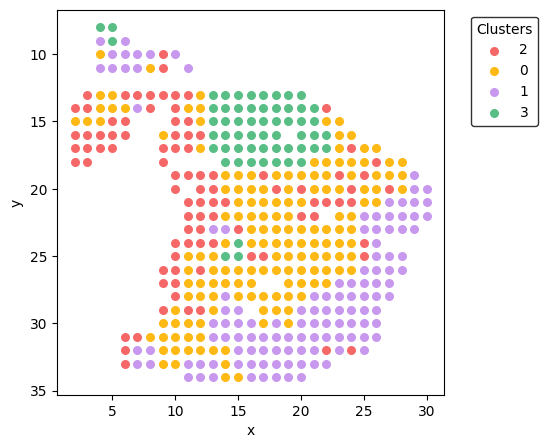

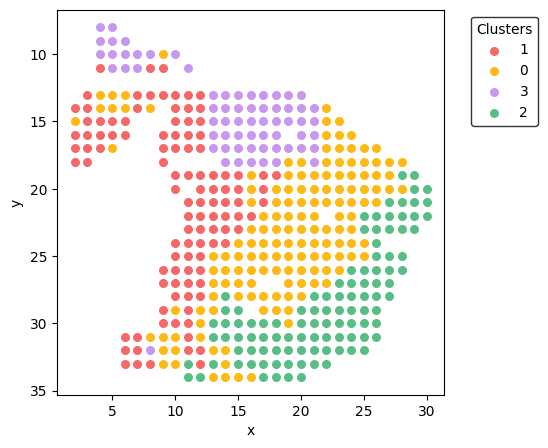

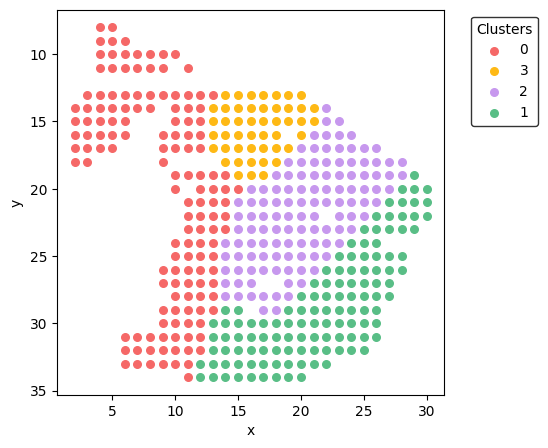

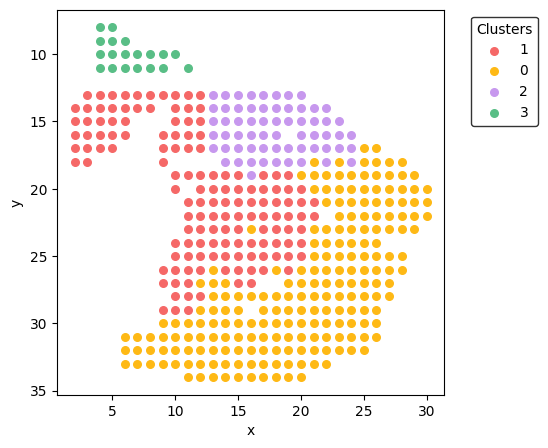

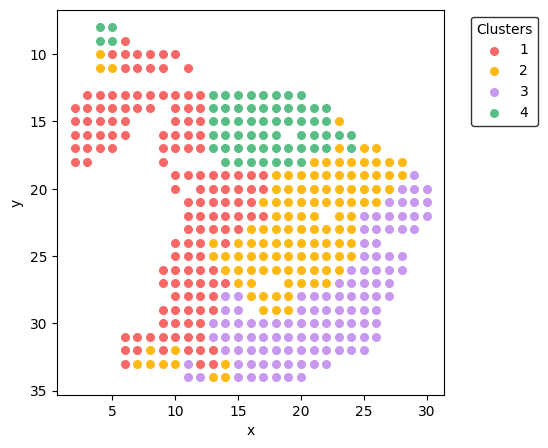

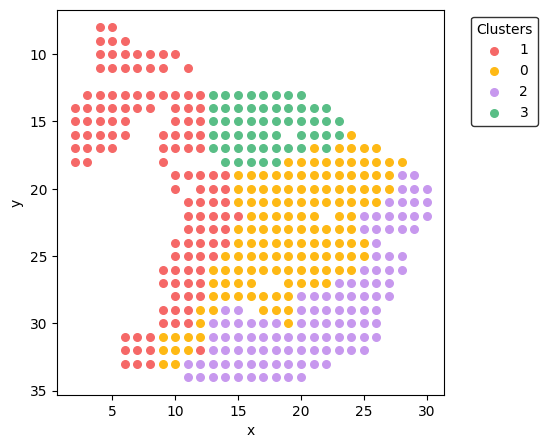

In [11]:
WEST_plt.WEST_scatter(adata_west, invert_y=True, s=30, save_path=file_path+'cls_WEST.pdf')
WEST_plt.WEST_scatter(adata_west, reps='true cluster', invert_y=True, s=30, save_path=file_path+'/cls_true.pdf')
WEST_plt.WEST_scatter(adata_west, reps='Leiden', invert_y=True, s=30, save_path=file_path+'cls_Leiden.pdf')
WEST_plt.WEST_scatter(adata_west, reps='SpaGCN', invert_y=True, s=30, save_path=file_path+'cls_SpaGCN.pdf')
WEST_plt.WEST_scatter(adata_west, reps='SpaceFlow', invert_y=True, s=30, save_path=file_path+'cls_SpaceFlow.pdf')
WEST_plt.WEST_scatter(adata_west, reps='SEDR', invert_y=True, s=30, save_path=file_path+'cls_SEDR.pdf')
WEST_plt.WEST_scatter(adata_west, reps='STAGATE', invert_y=True, s=30, save_path=file_path+'cls_STAGATE.pdf')
WEST_plt.WEST_scatter(adata_west, reps='DeepST', invert_y=True, s=30, save_path=file_path+'cls_DeepST.pdf')

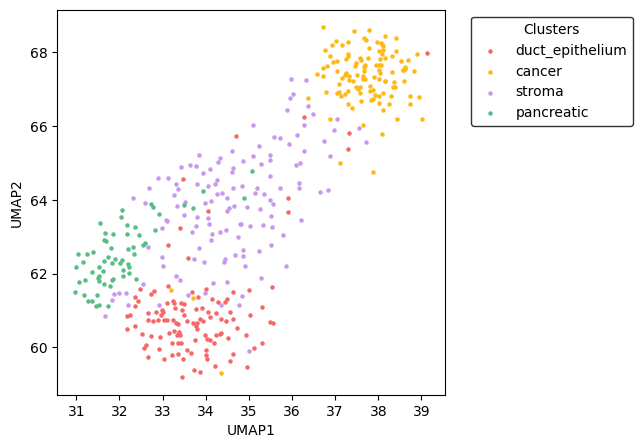

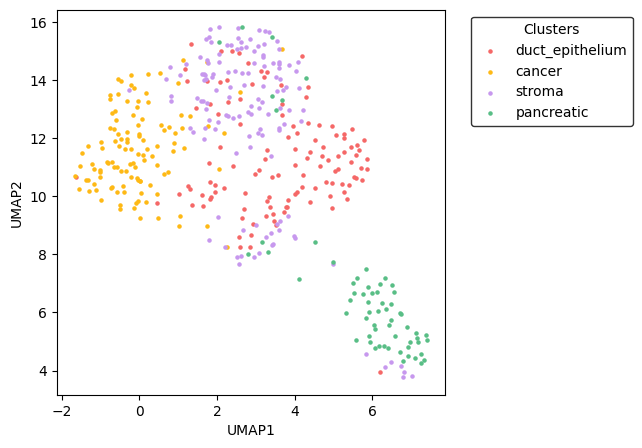

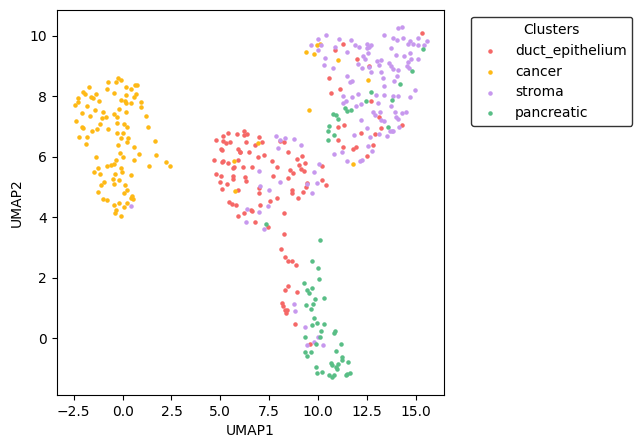

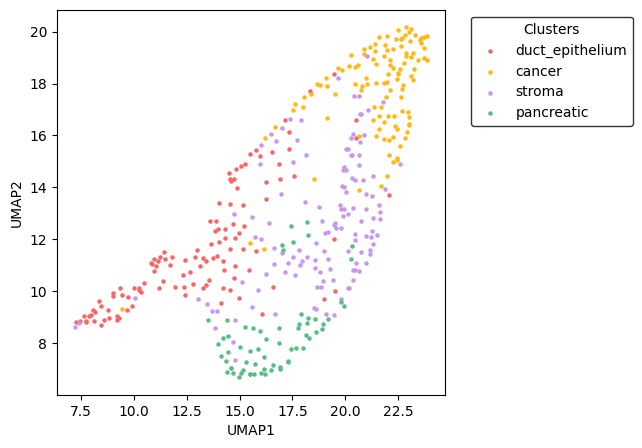

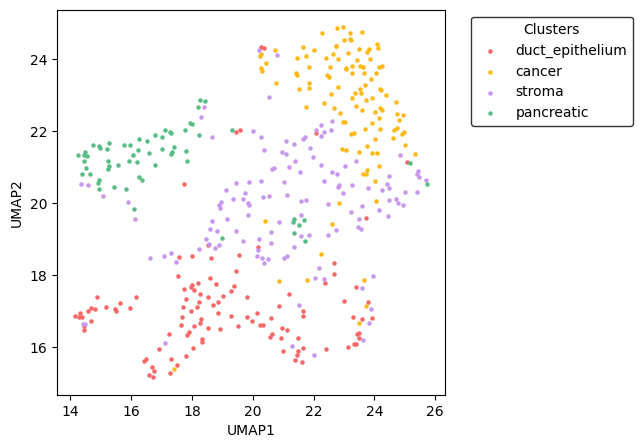

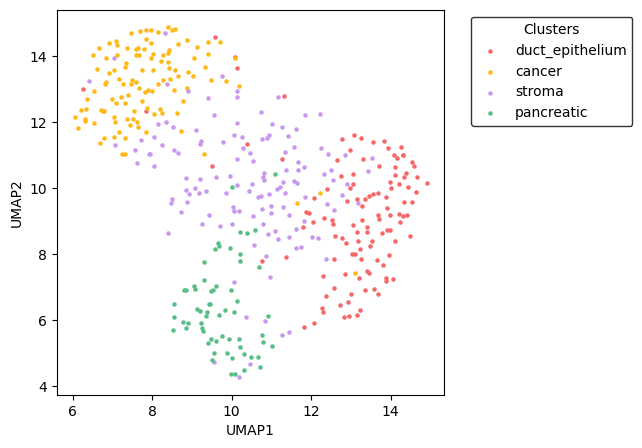

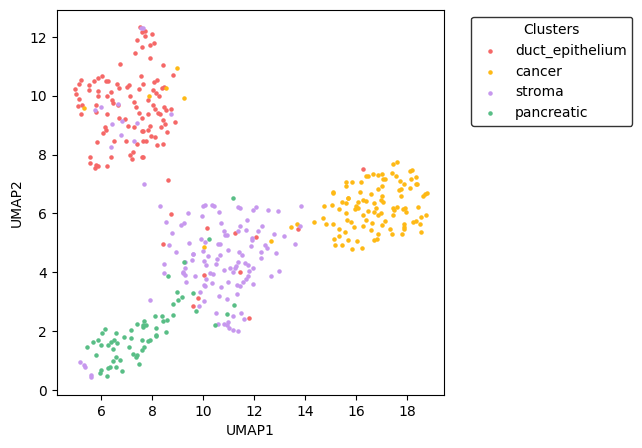

In [12]:
WEST_plt.WEST_umap(adata_west, save_path=file_path+'umap_WEST.pdf')
WEST_plt.WEST_umap(adata_west, reps='Leiden', save_path=file_path+'umap_Leiden.pdf')
WEST_plt.WEST_umap(adata_west, reps='SpaGCN', save_path=file_path+'umap_SpaGCN.pdf')
WEST_plt.WEST_umap(adata_west, reps='SpaceFlow', save_path=file_path+'umap_SpaceFlow.pdf')
WEST_plt.WEST_umap(adata_west, reps='SEDR', save_path=file_path+'umap_SEDR.pdf')
WEST_plt.WEST_umap(adata_west, reps='STAGATE', save_path=file_path+'umap_STAGATE.pdf')
WEST_plt.WEST_umap(adata_west, reps='DeepST', save_path=file_path+'umap_DeepST.pdf')